# 08. Natural Language Processing with TensorFlow

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-example-nlp-problems.png)
*A handful of example natural language processing (NLP) and natural language understanding (NLU) problems. These are also often referred to as sequence problems (going from one sequence to another).*

## What we're going to cover

Let's get specific hey?

* Downloading a text dataset
* Visualizing text data
* Converting text into numbers using tokenization
* Turning our tokenized text into an embedding
* Modelling a text dataset
  * Starting with a baseline (TF-IDF)
  * Building several deep learning text models
    * Dense, LSTM, GRU, Conv1D, Transfer learning
* Comparing the performance of each our models
* Combining our models into an ensemble
* Saving and loading a trained model
* Find the most wrong predictions

## How you should approach this notebook

You can read through the descriptions and the code (it should all run, except for the cells which error on purpose), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to write more code.

> 📖 **Resource:** See the full set of course materials on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning

### Terms

- **NLP**: Natural language processing
- **NLU**: Natural language understanding

In [1]:
# check for GPU
!nvidia-smi -L

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# Import series of helper functions for this notebook
from helper_functions import unzip_data,create_tensorboard_callback,plot_loss_curves,compare_historys

## Download a text dataset

Let's start by download a text dataset. We'll be using the [Real or Not?](https://www.kaggle.com/c/nlp-getting-started/data) datset from Kaggle which contains text-based Tweets about natural disasters. 

The Real Tweets are actually about diasters, for example:

```
Jetstar and Virgin forced to cancel Bali flights again because of ash from Mount Raung volcano
```

The Not Real Tweets are Tweets not about diasters (they can be on anything), for example:

```
'Education is the most powerful weapon which you can use to change the world.' Nelson #Mandela #quote
```

For convenience, the dataset has been [downloaded from Kaggle](https://www.kaggle.com/c/nlp-getting-started/data) (doing this requires a Kaggle account) and uploaded as a downloadable zip file. 

> 🔑 **Note:** The original downloaded data has not been altered to how you would download it from Kaggle.

Unzipping `nlp_getting_started.zip` gives the following 3 `.csv` files:
* `sample_submission.csv` - an example of the file you'd submit to the Kaggle competition of your model's predictions.
* `train.csv` - training samples of real and not real diaster Tweets.
* `test.csv` - testing samples of real and not real diaster Tweets.

## Visualizing a text dataset

Once you've acquired a new dataset to work with, what should you do first?

Explore it? Inspect it? Verify it? Become one with it?

All correct.

Remember the motto: visualize, visualize, visualize.

Right now, our text data samples are in the form of `.csv` files. For an easy way to make them visual, let's turn them into pandas DataFrame's.

> 📖 **Reading:** You might come across text datasets in many different formats. Aside from CSV files (what we're working with), you'll probably encounter `.txt` files and `.json` files too. For working with these type of files, I'd recommend reading the two following articles by RealPython:
* [How to Read and Write Files in Python](https://realpython.com/read-write-files-python/)
* [Working with JSON Data in Python](https://realpython.com/python-json/)

In [3]:
import pandas as pd
# import dataset
train_df = pd.read_csv("real_or_not/train.csv")
test_df = pd.read_csv("real_or_not/test.csv")
# check out number of dataset
print(f"training dataset: {len(train_df)} samples")
print(f"testing dataset: {len(test_df)} samples")
print(f"total samples: {len(train_df)+len(test_df)} samples")

training dataset: 7613 samples
testing dataset: 3263 samples
total samples: 10876 samples


In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


The training data we downloaded is probably shuffled already. But just to be sure, let's shuffle it again.

In [6]:
# shuffe training dataset
train_df = train_df.sample(frac=1,random_state=42) # shuffle with random_state=42 for reproducibility
train_df.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


Notice how the training data has a `"target"` column.

We're going to be writing code to find patterns (e.g. different combinations of words) in the `"text"` column of the training dataset to predict the value of the `"target"` column.

The test dataset doesn't have a `"target"` column.

```
Inputs (text column) -> Machine Learning Algorithm -> Outputs (target column)
```

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-text-classification-inputs-and-outputs.png)
*Example text classification inputs and outputs for the problem of classifying whether a Tweet is about a diaster or not.*

In [7]:
# check how many examples of each class
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

Since we have two target values, we're dealing with a **binary classification** problem.

It's fairly balanced too, about 60% negative class (`target = 0`) and 40% positive class (`target = 1`).

Where, 

* `1` = a real disaster Tweet
* `0` = not a real disaster Tweet

And what about the total number of samples we have?

Alright, seems like we've got a decent amount of training and test data. If anything, we've got an abundance of testing examples, usually a split of 90/10 (90% training, 10% testing) or 80/20 is suffice.

Okay, time to visualize, let's write some code to visualize random text samples.

> 🤔 **Question:** Why visualize random samples? You could visualize samples in order but this could lead to only seeing a certain subset of data. Better to visualize a substantial quantity (100+) of random samples to get an idea of the different kinds of data you're working with. In machine learning, never underestimate the power of randomness.

In [8]:
# let visualize some random training examples
import random

In [9]:
no_idx = 5
# create random indexes not higher than total number of samples
random_idx = random.randint(0,len(train_df)-no_idx)
for row in train_df[["text","target"]][random_idx:random_idx+no_idx].itertuples():
    index,text,target = row
    print(f"Index: {index}, Target: {target}","(real_disaster)" if target >0 else "(not real disaster)")
    print(f"Text:\n{text}")
    print("---\n")

Index: 5025, Target: 0 (not real disaster)
Text:
2 great new recipes; mudslide cake and so sorry stew! #GBBO
---

Index: 430, Target: 0 (not real disaster)
Text:
Arsonists being blamed for a blaze at a plastics recycling business in Adelaide | @pcaldicott7 reports. #7NewsAdl http://t.co/r1Xwdnvb0g
---

Index: 3523, Target: 1 (real_disaster)
Text:
Read an eyewitness account from #Hiroshima from this day in 1945 http://t.co/QUEDV2xxxX #LIFE
---

Index: 1808, Target: 1 (real_disaster)
Text:
Man killed in crash in Barrington Hills: A Hoffman Estates man was killed in a single-car crash Wednesday afte... http://t.co/b6NphxOrZg
---

Index: 7504, Target: 0 (not real disaster)
Text:
I'm an emotional wreck watching emmerdale
---



### Split data into training and validation sets

Since the test set has no labels and we need a way to evalaute our trained models, we'll split off some of the training data and create a validation set.

When our model trains (tries patterns in the Tweet samples), it'll only see data from the training set and we can see how it performs on unseen data using the validation set.

We'll convert our splits from pandas Series datatypes to lists of strings (for the text) and lists of ints (for the labels) for ease of use later.

To split our training dataset and create a validation dataset, we'll use Scikit-Learn's [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method and dedicate 10% of the training samples to the validation set.

In [10]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val = train_test_split(train_df['text'].to_numpy(),
                                              train_df['target'].to_numpy(),
                                              test_size=0.1, #dedicate 10% of samples to validation
                                              random_state=42 # random state for reproducibility
                                              )

In [11]:
x_pred = test_df['text'].to_numpy()
print(f"x_pred: {len(x_pred)} samples")

x_pred: 3263 samples


In [12]:
# Check the lengths
print(f"x_train: {len(x_train)} samples")
print(f"x_val: {len(x_val)} samples")
print(f"y_train: {len(y_train)} samples")
print(f"y_val: {len(y_val)} samples")

x_train: 6851 samples
x_val: 762 samples
y_train: 6851 samples
y_val: 762 samples


In [13]:
# view a piece of x_train,y_train samples
print(x_train[0])
print(y_train[0])

@mogacola @zamtriossu i screamed after hitting tweet
0


## Converting text into numbers

Wonderful! We've got a training set and a validation set containing Tweets and labels.

Our labels are in numerical form (`0` and `1`) but our Tweets are in string form.

> 🤔 **Question:** What do you think we have to do before we can use a machine learning algorithm with our text data? 

If you answered something along the lines of "turn it into numbers", you're correct. A machine learning algorithm requires its inputs to be in numerical form.

In NLP, there are two main concepts for turning text into numbers:
* **Tokenization** - A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:
  1. Using **word-level tokenization** with the sentence "I love TensorFlow" might result in "I" being `0`, "love" being `1` and "TensorFlow" being `2`. In this case, every word in a sequence considered a single **token**.
  2. **Character-level tokenization**, such as converting the letters A-Z to values `1-26`. In this case, every character in a sequence considered a single **token**.
  3. **Sub-word tokenization** is in between word-level and character-level tokenization. It involves breaking invidual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple **tokens**.
* **Embeddings** - An embedding is a representation of natural language which can be learned. Representation comes in the form of a **feature vector**. For example, the word "dance" could be represented by the 5-dimensional vector `[-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]`. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings: 
  1. **Create your own embedding** - Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)) and an embedding representation will be learned during model training.
  2. **Reuse a pre-learned embedding** - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-tokenization-vs-embedding.png)
*Example of **tokenization** (straight mapping from word to number) and **embedding** (richer representation of relationships between tokens).*

> 🤔 **Question:** What level of tokenzation should I use? What embedding should should I choose?

It depends on your problem. You could try character-level tokenization/embeddings and word-level tokenization/embeddings and see which perform best. You might even want to try stacking them (e.g. combining the outputs of your embedding layers using [`tf.keras.layers.concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate)). 

If you're looking for pre-trained word embeddings, [Word2vec embeddings](http://jalammar.github.io/illustrated-word2vec/), [GloVe embeddings](https://nlp.stanford.edu/projects/glove/) and many of the options available on [TensorFlow Hub](https://tfhub.dev/s?module-type=text-embedding) are great places to start.

> 🔑 **Note:** Much like searching for a pre-trained computer vision model, you can search for pre-trained word embeddings to use for your problem. Try searching for something like "use pre-trained word embeddings in TensorFlow".

### Text vectorization (tokenization)

Enough talking about tokenization and embeddings, let's create some.

We'll practice tokenzation (mapping our words to numbers) first.

To tokenize our words, we'll use the helpful preprocessing layer [`tf.keras.layers.experimental.preprocessing.TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization).

The `TextVectorization` layer takes the following parameters:
* `max_tokens` - The maximum number of words in your vocabulary (e.g. 20000 or the number of unique words in your text), includes a value for OOV (out of vocabulary) tokens. 
* `standardize` - Method for standardizing text. Default is `"lower_and_strip_punctuation"` which lowers text and removes all punctuation marks.
* `split` - How to split text, default is `"whitespace"` which splits on spaces.
* `ngrams` - How many words to contain per token split, for example, `ngrams=2` splits tokens into continuous sequences of 2.
* `output_mode` -  How to output tokens, can be `"int"` (integer mapping), `"binary"` (one-hot encoding), `"count"` or `"tf-idf"`. See documentation for more.
* `output_sequence_length` - Length of tokenized sequence to output. For example, if `output_sequence_length=150`, all tokenized sequences will be 150 tokens long.
* `pad_to_max_tokens` - Defaults to `False`, if `True`, the output feature axis will be padded to `max_tokens` even if the number of unique tokens in the vocabulary is less than `max_tokens`. Only valid in certain modes, see docs for more.

Let's see it in action.

In [14]:
import tensorflow as tf

print(tf.__version__)

2.6.0


In [15]:
from tensorflow.keras.layers import TextVectorization
# Note: in TensorFlow 2.6+, you no longer need "layers.experimental.preprocessing"
# you can use: "tf.keras.layers.TextVectorization", see https://github.com/tensorflow/tensorflow/releases/tag/v2.6.0 for more

In [16]:
#Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split ="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None # how long should the output sequence of tokens be
                                    # pad_to_max_tokens=True # Not valid if using max_tokens=None
                                   )

We've initialized a `TextVectorization` object with the default settings but let's customize it a little bit for our own use case.

In particular, let's set values for `max_tokens` and `output_sequence_length`.

For `max_tokens` (the number of words in the vocabulary), multiples of 10,000 (`10,000`, `20,000`, `30,000`) or the exact number of unique words in your text (e.g. `32,179`) are common values.

For our use case, we'll use `10,000`.

And for the `output_sequence_length` we'll use the average number of tokens per Tweet in the training set. But first, we'll need to find it.

In [17]:
# Find average of tokens (words) in training Tweets
total_words = sum([len(i.split()) for i in x_train])
no_tokens = round(total_words/len(x_train))
print(f"total_words: {total_words}")
print(f"no_tokens: {no_tokens}")

total_words: 102087
no_tokens: 15


Now let's create another `TextVectorization` object using our custom parameters.

In [18]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = 'int',
                                    output_sequence_length=no_tokens
                                   )

Beautiful!

To map our `TextVectorization` instance `text_vectorizer` to our data, we can call the `adapt()` method on it whilst passing it our training text.

In [19]:
text_vectorizer.adapt(x_train)

Training data mapped! Let's try our `text_vectorizer` on a custom sentence (one similar to what you might see in the training data).

In [20]:
#Create sample setence and tokenize it
sample_sentence= "There is a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

Wonderful, it seems we've got a way to turn our text into numbers (in this case, word-level tokenization). Notice the 0's at the end of the returned tensor, this is because we set `output_sequence_length=15`, meaning no matter the size of the sequence we pass to `text_vectorizer`, it always returns a sequence with a length of 15.

How about we try our `text_vectorizer` on a few random sentences?

In [21]:
# Choose a random setence from the training dataset and tokenize it
random_sentence = random.choice(x_train)
print(f"Original text:\n{random_sentence}\nVectorized:\n{text_vectorizer(random_sentence)}")

Original text:
Rt hirochii0: There is no country that making fun of Hiroshima 's tragedy but Korea. http://t.co/And1Btizao #Indonesia #Malaysia #Jamaica #Û_
Vectorized:
[  96    1   74    9   40  782   16  572  604    6  130  236  360   30
 3700]


Looking good!

Finally, we can check the unique tokens in our vocabulary using the `get_vocabulary()` method.

In [22]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # order from the most appearance
top_words = words_in_vocab[:5] # most common token [UNK] token for "unknown" words
bottom_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_words}")
print(f"Bottom 5 least common words: {bottom_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

We've got a way to map our text to numbers. How about we go a step further and turn those numbers into an embedding?

The powerful thing about an embedding is it can be learned during training. This means rather than just being static (e.g. `1` = I, `2` = love, `3` = TensorFlow), a word's numeric representation can be improved as a model goes through data samples.

We can see what an embedding of a word looks like by using the [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer. 

The main parameters we're concerned about here are:
* `input_dim` - The size of the vocabulary (e.g. `len(text_vectorizer.get_vocabulary()`).
* `output_dim` - The size of the output embedding vector, for example, a value of `100` outputs a  feature vector of size 100 for each word.
* `embeddings_initializer` - How to initialize the embeddings matrix, default is `"uniform"` which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.
* `input_length` - Length of sequences being passed to embedding layer.

Knowing these, let's make an embedding layer.

In [23]:
tf.random.set_seed(42)
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                            output_dim=128, # set size of embedding vector, each number convert to output_dim number
                            embeddings_initializer="uniform", # defaut, initialize randomly
                            input_length=no_tokens, # how long is each input
                            name="embedding_1")
embedding

Excellent, notice how `embedding` is a TensoFlow layer? This is important because we can use it as part of a model, meaning its parameters (word representations) can be updated and improved as the model learns.

How about we try it out on a sample sentence?

In [24]:
# Get a random sentence from training set
random_setence = random.choice(x_train)
# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
print(f"Original text:\n{random_sentence}\nEmbedded {sample_embed.shape}:\n{sample_embed}")

Original text:
Rt hirochii0: There is no country that making fun of Hiroshima 's tragedy but Korea. http://t.co/And1Btizao #Indonesia #Malaysia #Jamaica #Û_
Embedded (1, 15, 128):
[[[-0.04776652 -0.04322071  0.03497444 ... -0.02333785  0.04645089
    0.02155567]
  [ 0.03977952 -0.03782602 -0.03646283 ...  0.00236253  0.03332629
    0.02803668]
  [-0.04738555 -0.0471351   0.04524391 ...  0.02124399  0.00585047
   -0.04879045]
  ...
  [-0.0165316  -0.03510038  0.0445965  ... -0.01930827  0.04231616
    0.04728869]
  [-0.00528122  0.02229692 -0.01471323 ... -0.01874887  0.0084453
    0.029084  ]
  [-0.02091447  0.03727654 -0.03265884 ...  0.03280319 -0.03501606
    0.04589789]]]


Each token in the sentence gets turned into a length 128 feature vector.

In [25]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.04776652, -0.04322071,  0.03497444, -0.02849153,  0.01001883,
        0.03615249, -0.03636273,  0.00181737, -0.03095951,  0.03299289,
       -0.01690693,  0.00449812, -0.02110614, -0.0413339 , -0.04701787,
        0.03334088,  0.01867853,  0.02049876,  0.01632055,  0.00330683,
        0.01552968, -0.02998798,  0.03739282, -0.01968045,  0.02917535,
       -0.00200158, -0.045313  , -0.02446351, -0.04088856, -0.03098938,
       -0.01291069, -0.00674145, -0.00251269,  0.02630253,  0.02724084,
        0.02817651, -0.00933322,  0.04768895, -0.02043082,  0.02713052,
        0.00251096, -0.02965219,  0.01193519, -0.01253104, -0.01186951,
       -0.00858345,  0.01329798, -0.01616744, -0.00612741, -0.00507989,
        0.03780717, -0.01353563,  0.0369866 ,  0.0321689 ,  0.03546727,
       -0.00752349,  0.00447839, -0.01659516, -0.0238764 , -0.01298834,
        0.03306614, -0.02332057, -0.04947395, -0.03651677,  0.03678372,
        0.036403

These values might not mean much to us but they're what our computer sees each word as. When our model looks for patterns in different samples, these values will be updated as necessary.

> 🔑 **Note:** The previous two concepts (tokenization and embeddings) are the foundation for many NLP tasks. So if you're not sure about anything, be sure to research and conduct your own experiments to further help your understanding.

## Modelling a text dataset

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-inputs-and-outputs-with-shapes-and-models-were-going-to-build.png)
*Once you've got your inputs and outputs prepared, it's a matter of figuring out which machine learning model to build in between them to bridge the gap.*

Now that we've got a way to turn our text data into numbers, we can start to build machine learning models to model it.

To get plenty of practice, we're going to build a series of different models, each as its own experiment. We'll then compare the results of each model and see which one performed best.

More specifically, we'll be building the following:
* **Model 0**: Naive Bayes (baseline)
* **Model 1**: Feed-forward neural network (dense model)
* **Model 2**: LSTM model
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
* **Model 5**: 1D Convolutional Neural Network
* **Model 6**: TensorFlow Hub Pretrained Feature Extractor
* **Model 7**: Same as model 6 with 10% of training data

Model 0 is the simplest to acquire a baseline which we'll expect each other of the other deeper models to beat.

Each experiment will go through the following steps:
* Construct the model
* Train the model
* Make predictions with the model
* Track prediction evaluation metrics for later comparison

Let's get started.

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll create a Scikit-Learn Pipeline using the TF-IDF (term frequency-inverse document frequency) formula to convert our words to numbers and then model them with the [Multinomial Naive Bayes algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB). This was chosen via referring to the [Scikit-Learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

> 📖 **Reading:** The ins and outs of TF-IDF algorithm is beyond the scope of this notebook, however, the curious reader is encouraged to check out the [Scikit-Learn documentation for more](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting).

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf",TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf",MultinomialNB()) # model the text
])

model_0

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# Fit the pipeline to training data
model_0.fit(x_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

The benefit of using a shallow model like Multinomial Naive Bayes is that training is very fast.

Let's evaluate our model and find our baseline metric.

In [28]:
baseline_score = model_0.score(x_val,y_val)
print(f"Our baseline model achives an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achives an accuracy of: 79.27%


In [29]:
# Make predictions
baseline_preds = model_0.predict(x_pred)
baseline_preds[:20]

array([1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
      dtype=int64)

In [30]:
# Make prediction from train dataset
y_pred = model_0.predict(x_train)

### Creating an evaluation function for our model experiments

We could evaluate these as they are but since we're going to be evaluating several models in the same way going forward, let's create a helper function which takes an array of predictions and ground truth labels and computes the following:
* Accuracy
* Precision
* Recall
* F1-score

> 🔑 **Note:** Since we're dealing with a classification problem, the above metrics are the most appropriate. If we were working with a regression problem, other metrics such as MAE (mean absolute error) would be a better choice.

In [31]:
# Function to evaluate: accuracy,precision,recall,f1-score
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

def eval_model(y_true,y_pred):
    '''
    Calculates model accuracy, precision,recall, and f1 score of a binary classification model.
    Args:
        y_true: true labels in the form of a 1D array
        y_pred: predicted labels in the form of a 1D array
    Return:
        a dictionary of accuracy,precision,recall,f1-score
    '''
    # Calculate model accuracy
    accuracy = accuracy_score(y_true,y_pred) *100
    # Calculate model precision, recall and f1 score using weighted average
    precision,recall,f1,_ = precision_recall_fscore_support(y_true,y_pred,average='weighted')
    result = {"accuracy":accuracy,
              "precision":precision,
              "recall":recall,
              "f1":f1
              }
    return result

In [32]:
# get baseline results
baseline_results = eval_model(y_true=y_train,
                                    y_pred=y_pred)
baseline_results

{'accuracy': 88.71697562399649,
 'precision': 0.8972275432217538,
 'recall': 0.887169756239965,
 'f1': 0.8847145740998287}

### Model 1: A simple dense model

The first "deep" model we're going to build is a single layer dense model. In fact, it's barely going to have a single layer. 

It'll take our text and labels as input, tokenize the text, create an embedding, find the average of the embedding (using Global Average Pooling) and then pass the average through a fully connected layer with one output unit and a sigmoid activation function.

If the previous sentence sounds like a mouthful, it'll make sense when we code it out (remember, if in doubt, code it out).

And since we're going to be building a number of TensorFlow deep learning models, we'll import our `create_tensorboard_callback()` function from `helper_functions.py` to keep track of the results of each. 

In [33]:
#Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# create directory to save tensorboard logs
SAVE_DIR = "model_logs"

In [34]:
# Build model with functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype="string") #inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the 
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding for better accuracy
outputs = layers.Dense(1,activation='sigmoid')(x) # create the output layer,want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs,outputs,name="model_1_dense") # construct the model

In [35]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


Looking good. Our model takes a 1-dimensional string as input (in our case, a Tweet), it then tokenizes the string using `text_vectorizer` and creates an embedding using `embedding`.

We then (optionally) pool the outputs of the embedding layer to reduce the dimensionality of the tensor we pass to the output layer.

> 🛠 **Exercise:** Try building `model_1` with and without a `GlobalAveragePooling1D()` layer after the `embedding` layer. What happens? Why do you think this is?

Finally, we pass the output of the pooling layer to a dense layer with sigmoid activation (we use sigmoid since our problem is binary classification).

Before we can fit our model to the data, we've got to compile it. Since we're working with binary classification, we'll use `"binary_crossentropy"` as our loss function and the Adam optimizer.

In [36]:
# Compile model
model_1.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [37]:
# Fit the model
# input sentences can be a list of strings due to text preprocessing layer built-in model
model_1_history = model_1.fit(x_train,y_train,epochs=5,validation_data=(x_val,y_val),
                             callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20230102-074601
Epoch 1/5
215/215 [==============================] - 9s 39ms/step - loss: 0.6094 - accuracy: 0.6916 - val_loss: 0.5357 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 8s 36ms/step - loss: 0.4410 - accuracy: 0.8189 - val_loss: 0.4691 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 7s 34ms/step - loss: 0.3463 - accuracy: 0.8605 - val_loss: 0.4590 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 7s 34ms/step - loss: 0.2848 - accuracy: 0.8923 - val_loss: 0.4641 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 8s 35ms/step - loss: 0.2380 - accuracy: 0.9118 - val_loss: 0.4767 - val_accuracy: 0.7874


In [38]:
# evaluate model
model_1.evaluate(x_val,y_val)

24/24 [==============================] - 0s 3ms/step - loss: 0.4767 - accuracy: 0.7874


[0.4766846001148224, 0.787401556968689]

In [39]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.00073165,  0.01504797, -0.03425453, ..., -0.0440354 ,
         -0.01042278,  0.01876434],
        [ 0.04135866, -0.03945084, -0.03811939, ...,  0.00464735,
          0.03163555,  0.02928306],
        [ 0.00684034,  0.05363132, -0.00241555, ..., -0.07082175,
         -0.04750701,  0.01448254],
        ...,
        [-0.03301444, -0.0052493 , -0.04209725, ...,  0.02028764,
          0.00308807,  0.02215792],
        [ 0.00692343,  0.05942352, -0.01975194, ..., -0.0619906 ,
         -0.01018394,  0.03510419],
        [-0.0372346 ,  0.06267187, -0.07451148, ..., -0.02367217,
         -0.08643331,  0.01742156]], dtype=float32)>]

In [40]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


And since we tracked our model's training logs with TensorBoard, how about we visualize them?

We can do so by uploading our TensorBoard log files (contained in the `model_logs` directory) to [TensorBoard.dev](https://tensorboard.dev/).

> 🔑 **Note:** Remember, whatever you upload to TensorBoard.dev becomes public. If there are training logs you don't want to share, don't upload them.

In [41]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs \
#   --name "First deep model on text data" \
#   --description "Trying a dense model with an embedding layer" \
#   --one_shot # exits the uploader when upload has finished

In [42]:
# If you need to remove previous experiments, you can do so using the following command
# !tensorboard dev delete --experiment_id EXPERIMENT_ID_TO_DELETE

The TensorBoard.dev experiment for our first deep model can be viewed here: https://tensorboard.dev/experiment/5d1Xm10aT6m6MgyW3HAGfw/

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-tensorboard-dense-model-training-curves.png)

*What the training curves of our model look like on TensorBoard. From looking at the curves can you tell if the model is overfitting or underfitting?*

Beautiful! Those are some colorful training curves. Would you say the model is overfitting or underfitting?

We've built and trained our first deep model, the next step is to make some predictions with it.

In [43]:
# Make predictions (these come back in the form of probabilities)
model_1_preds = model_1.predict(x_pred)
print(model_1_preds.shape)
model_1_preds[:10]

(3263, 1)


array([[0.74268913],
       [0.46518314],
       [0.96204746],
       [0.52281755],
       [0.9871582 ],
       [0.83201915],
       [0.04111165],
       [0.08296731],
       [0.03741345],
       [0.1755347 ]], dtype=float32)

Since our final layer uses a sigmoid activation function, we get our predictions back in the form of probabilities.

To convert them to prediction classes, we'll use `tf.round()`, meaning prediction probabilities below 0.5 will be rounded to 0 and those above 0.5 will be rounded to 1.

> 🔑 **Note:** In practice, the output threshold of a sigmoid prediction probability doesn't necessarily have to 0.5. For example, through testing, you may find that a cut off of 0.25 is better for your chosen evaluation metrics. A common example of this threshold cutoff is the [precision-recall tradeoff](https://www.machinelearningaptitude.com/topics/machine-learning/what-is-precision-recall-tradeoff/#:~:text=precision%2Drecall%20tradeoff%20occur%20due,the%20threshold%20of%20the%20classifier.&text=When%20threshold%20is%20decreased%20to,but%20precision%20decreases%20to%200.4.).

In [44]:
#Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_preds)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0.], dtype=float32)>

In [45]:
y_pred = model_1.predict(x_val)
y_pred = tf.squeeze(tf.round(y_pred))

In [46]:
# Calculate model_1 metrics
model_1_metrics = eval_model(y_true=y_val,y_pred=y_pred)
model_1_metrics

{'accuracy': 78.74015748031496,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497,
 'f1': 0.7846966492209201}

In [47]:
model_1_metrics.values()

dict_values([78.74015748031496, 0.7914920592553047, 0.7874015748031497, 0.7846966492209201])

In [48]:
baseline_results.values()

dict_values([88.71697562399649, 0.8972275432217538, 0.887169756239965, 0.8847145740998287])

In [49]:
# Compare dense model and bayer model
import numpy as np
np.array(list(model_1_metrics.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [50]:
# Create a helper function to compare our baseline results to new model results
def compare_metrics(metric1,metric2):
    '''
    Compare metrics of 2 model
    Args:
        metric1: metric of model1
        metric2: metric of model2
    Return:
        Print out comparision
    '''
    for key,value in baseline_results.items():
        value_1 = metric1[key]
        value_2 = metric2[key]
        print(f"Model1 {key}:{value_1:.2f},\tModel2 {key}:{value_2:.2f},\tDifference:{value_2-value_1:.2f}")

compare_metrics(baseline_results,model_1_metrics)

Model1 accuracy:88.72,	Model2 accuracy:78.74,	Difference:-9.98
Model1 precision:0.90,	Model2 precision:0.79,	Difference:-0.11
Model1 recall:0.89,	Model2 recall:0.79,	Difference:-0.10
Model1 f1:0.88,	Model2 f1:0.78,	Difference:-0.10


## Visualizing learned embeddings

Our first model (`model_1`) contained an embedding layer (`embedding`) which learned a way of representing words as feature vectors by passing over the training data.

Hearing this for the first few times may sound confusing.

So to further help understand what a text embedding is, let's visualize the embedding our model learned.

To do so, let's remind ourselves of the words in our vocabulary.

In [51]:
# Get the vocabulary from text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab),words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [52]:
# Get the weight matrix of embedding layer
# these are the numerical patterns betweeen the text in the training dataset the model has learned
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is embedding_dim size vector)

(10000, 128)


In [53]:
embed_weights[0]

array([ 7.31648994e-04,  1.50479684e-02, -3.42545286e-02,  1.41229685e-02,
       -6.55442104e-02, -4.79772658e-04,  5.30462991e-03,  2.19666418e-02,
       -9.22617316e-03, -4.55674641e-02, -1.21224485e-03,  7.48404069e-03,
       -1.80333238e-02, -1.36849955e-02, -1.04086287e-02,  2.15889122e-02,
       -3.48343365e-02,  2.13441718e-02,  3.16999927e-02, -4.96902205e-02,
        4.19809632e-02,  2.39376035e-02, -5.70377447e-02, -1.34752819e-03,
       -2.74713500e-03, -3.43280882e-02, -6.49535190e-03, -4.77883555e-02,
        1.87852345e-02, -2.46752203e-02,  6.48885444e-02, -1.57031752e-02,
        1.62483491e-02, -1.53555227e-02, -1.92866568e-02, -4.79918048e-02,
        5.23341820e-02,  1.94401704e-02, -3.77332158e-02,  3.65230441e-02,
       -1.15618221e-02,  1.30226417e-02,  6.61792681e-02, -2.59836297e-02,
        1.11353109e-02,  3.54380757e-02, -1.12592978e-02, -5.35947457e-02,
        4.22944427e-02, -3.71337309e-02,  2.89598834e-02,  1.57956928e-02,
        6.55973032e-02,  

Now we've got these two objects, we can use the [Embedding Projector tool](http://projector.tensorflow.org/_) to visualize our embedding. 

To use the Embedding Projector tool, we need two files:
* The embedding vectors (same as embedding weights).
* The meta data of the embedding vectors (the words they represent - our vocabulary).

Right now, we've got of these files as Python objects. To download them to file, we're going to [use the code example available on the TensorFlow word embeddings tutorial page](https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk).


In [54]:
# Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
    if num == 0: 
        continue # skip padding token
    vec = embed_weights[num]
    out_m.write(word + "\n") # write words to file
    out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

# # Download files locally to upload to Embedding Projector
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download("embedding_vectors.tsv")
#   files.download("embedding_metadata.tsv")

![](cap.png)
Once you've downloaded the embedding vectors and metadata, you can visualize them using Embedding Vector tool:
1. Go to  http://projector.tensorflow.org/
2. Click on "Load data"
3. Upload the two files you downloaded (`embedding_vectors.tsv` and `embedding_metadata.tsv`)
4. Explore
5. Optional: You can share the data you've created by clicking "Publish"

What do you find?

Are words with similar meanings close together?

Remember, they might not be. The embeddings we downloaded are how our model interprets words, not necessarily how we interpret them. 

Also, since the embedding has been learned purely from Tweets, it may contain some strange values as Tweets are a very unique style of natural language.

> 🤔 **Question:** Do you have to visualize embeddings every time?

No. Although helpful for gaining an intuition of what natural language embeddings are, it's not completely necessary. Especially as the dimensions of your vocabulary and embeddings grow, trying to comprehend them would become an increasingly difficult task.

### Model 2: LSTM

With all this talk of what RNN's are and what they're good for, I'm sure you're eager to build one.

We're going to start with an LSTM-powered RNN.

To harness the power of the LSTM cell (LSTM cell and LSTM layer are often used interchangably) in TensorFlow, we'll use [`tensorflow.keras.layers.LSTM()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-RNN-architecture-coloured-block-edition.png)
*Coloured block example of the structure of an recurrent neural network.*

Our model is going to take on a very similar structure to `model_1`:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

The main difference will be that we're going to add an LSTM layer between our embedding and output.

And to make sure we're not getting reusing trained embeddings (this would involve data leakage between models, leading to an uneven comparison later on), we'll create another embedding layer (`model_2_embedding`) for our model. The `text_vectorizer` layer can be reused since it doesn't get updated during training.

> 🔑 **Note:** The reason we use a new embedding layer for each model is since the embedding layer is a *learned* representation of words (as numbers), if we were to use the same embedding layer (`embedding_1`) for each model, we'd be mixing what one model learned with the next. And because we want to compare our models later on, starting them with their own embedding layer each time is a better idea.

In [55]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers

# create embedding layer
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                    output_dim=128,
                                    embeddings_initializer='uniform',
                                    input_length=no_tokens,
                                    name ='embedding_2')

# create LSTM model
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # (64 + 128 +1)*64*4
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1,activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs,outputs,name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [56]:
# summary model
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


Looking good! You'll notice a fair few more trainable parameters within our LSTM layer than `model_1`. 

If you'd like to know where this number comes from, I recommend going through the above resources as well the following on calculating the number of parameters in an LSTM cell:
* [Stack Overflow answer to calculate the number of parameters in an LSTM cell](https://stackoverflow.com/questions/38080035/how-to-calculate-the-number-of-parameters-of-an-lstm-network) by Marcin Możejko
* [Calculating number of parameters in a LSTM unit and layer](https://medium.com/@priyadarshi.cse/calculating-number-of-parameters-in-a-lstm-unit-layer-7e491978e1e4) by Shridhar Priyadarshi

Now our first RNN model's compiled let's fit it to our training data, validating it on the validation data and tracking its training parameters using our TensorBoard callback.

![](cap2.png)

`num_params = [(num_units + input_dim + 1) * num_units] * 4`

num_units + input_dim: concat [h(t-1), x(t)]

+ 1: bias

* 4: there are 4 neural network layers (yellow box) {W_forget, W_input, W_output, W_cell}

`model.add(LSTM(units=256, input_dim=4096, input_length=16))`

`[(256 + 4096 + 1) * 256] * 4 = 4457472`

PS: num_units = num_hidden_units = output_dims
        
> 🔑 **Note:** Reading the documentation for the [TensorFlow LSTM layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM), you'll find a plethora of parameters. Many of these have been tuned to make sure they compute as fast as possible. The main ones you'll be looking to adjust are `units` (number of hidden units) and `return_sequences` (set this to `True` when stacking LSTM or other recurrent layers).

Now we've got our LSTM model built, let's compile it using `"binary_crossentropy"` loss and the Adam optimizer.

In [57]:
# compile model
model_2.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [58]:
# fit model
model_2_history = model_2.fit(x_train,y_train,epochs=5,validation_data = (x_val,y_val),
                             callbacks=[create_tensorboard_callback(SAVE_DIR, "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230102-074643
Epoch 1/5
215/215 [==============================] - 12s 48ms/step - loss: 0.5100 - accuracy: 0.7416 - val_loss: 0.4566 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 10s 44ms/step - loss: 0.3176 - accuracy: 0.8717 - val_loss: 0.5138 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 10s 44ms/step - loss: 0.2201 - accuracy: 0.9152 - val_loss: 0.5858 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 10s 45ms/step - loss: 0.1556 - accuracy: 0.9428 - val_loss: 0.6041 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 10s 46ms/step - loss: 0.1076 - accuracy: 0.9594 - val_loss: 0.8746 - val_accuracy: 0.7507


In [59]:
# Make predictions on the validation dataset
y_pred = model_2.predict(x_val)
y_pred.shape,y_pred[:10]

((762, 1),
 array([[0.00712609],
        [0.7873687 ],
        [0.99963766],
        [0.05679145],
        [0.00258222],
        [0.9996237 ],
        [0.9217019 ],
        [0.9997993 ],
        [0.9994954 ],
        [0.6645754 ]], dtype=float32))

In [60]:
#Round out predictions and reduce to 1-dim array
y_pred = tf.squeeze(tf.round(y_pred))
y_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [61]:
model_2_metrics = eval_model(y_true=y_val,y_pred=y_pred)
model_2_metrics

{'accuracy': 75.06561679790026,
 'precision': 0.7510077975908164,
 'recall': 0.7506561679790026,
 'f1': 0.7489268622514025}

In [62]:
# Compare model 2 to baseline model
compare_metrics(baseline_results,model_2_metrics)

Model1 accuracy:88.72,	Model2 accuracy:75.07,	Difference:-13.65
Model1 precision:0.90,	Model2 precision:0.75,	Difference:-0.15
Model1 recall:0.89,	Model2 recall:0.75,	Difference:-0.14
Model1 f1:0.88,	Model2 f1:0.75,	Difference:-0.14


### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

> 📖 **Resource:** A full explanation of the GRU cell is beyond the scope of this noteook but I'd suggest the following resources to learn more:
* [Gated Recurrent Unit](https://en.wikipedia.org/wiki/Gated_recurrent_unit) Wikipedia page
* [Understanding GRU networks](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be) by Simeon Kostadinov

To use the GRU cell in TensorFlow, we can call the [`tensorflow.keras.layers.GRU()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) class.

The architecture of the GRU-powered model will follow the same structure we've been using:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

Again, the only difference will be the layer(s) we use between the embedding and the output.

In [63]:
#Set random seed and create embedding layer (new embedding layer for each model)
from tensorflow.keras import layers
tf.random.set_seed(42)
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=no_tokens,
                                     name="embedding_3")

# build an RNN using the GRU cell
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x= layers.GRU(64,activation='relu')(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs,outputs,name="model_3_GRU")

In [64]:
# summary model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [65]:
# compile the model
model_3.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

Notice the difference in number of trainable parameters between `model_2` (LSTM) and `model_3` (GRU). The difference comes from the LSTM cell having more trainable parameters than the GRU cell.

We'll fit our model just as we've been doing previously. We'll also track our models results using our `create_tensorboard_callback()` function.

In [66]:
# train model
model_3_history = model_3.fit(x_train,y_train,epochs=5,validation_data=(x_val,y_val),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,"GRU")])

Saving TensorBoard log files to: model_logs/GRU/20230102-074736
Epoch 1/5
215/215 [==============================] - 12s 46ms/step - loss: 0.5585 - accuracy: 0.6999 - val_loss: 0.4518 - val_accuracy: 0.7913
Epoch 2/5
215/215 [==============================] - 9s 43ms/step - loss: 0.3368 - accuracy: 0.8599 - val_loss: 0.4918 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 9s 43ms/step - loss: 0.2229 - accuracy: 0.9129 - val_loss: 0.5878 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 9s 43ms/step - loss: 0.1514 - accuracy: 0.9407 - val_loss: 0.8036 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 9s 43ms/step - loss: 0.1063 - accuracy: 0.9583 - val_loss: 0.8946 - val_accuracy: 0.7717


In [67]:
# predict and convert prediction probabilities to prediction classes
y_pred = model_3.predict(x_val)
y_pred = tf.squeeze((tf.round(y_pred)))

In [68]:
# Calculate metric
model_3_metrics = eval_model(y_true=y_val,y_pred=y_pred)
model_3_metrics

{'accuracy': 77.16535433070865,
 'precision': 0.7715668446582516,
 'recall': 0.7716535433070866,
 'f1': 0.7706989403422689}

In [69]:
# Compare model 2 to baseline model
compare_metrics(baseline_results,model_3_metrics)

Model1 accuracy:88.72,	Model2 accuracy:77.17,	Difference:-11.55
Model1 precision:0.90,	Model2 precision:0.77,	Difference:-0.13
Model1 recall:0.89,	Model2 recall:0.77,	Difference:-0.12
Model1 f1:0.88,	Model2 f1:0.77,	Difference:-0.11


### Model 4: Bidirectonal RNN model 

Look at us go! We've already built two RNN's with GRU and LSTM cells. Now we're going to look into another kind of RNN, the bidirectional RNN.

A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.

Intuitively, this can be thought of as if you were reading a sentence for the first time in the normal fashion (left to right) but for some reason it didn't make sense so you traverse back through the words and go back over them again (right to left).

In practice, many sequence models often see and improvement in performance when using bidirectional RNN's.

However, this improvement in performance often comes at the cost of longer training times and increased model parameters (since the model goes left to right and right to left, the number of trainable parameters doubles).

Okay enough talk, let's build a bidirectional RNN.

Once again, TensorFlow helps us out by providing the [`tensorflow.keras.layers.Bidirectional`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) class. We can use the `Bidirectional` class to wrap our existing RNNs, instantly making them bidirectional.

In [70]:
# Set random seed and create embedding layer(new embedding layer for each model)
from tensorflow.keras import layers
tf.random.set_seed(42)
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                    output_dim=128,
                                    embeddings_initializer='uniform',
                                    input_length=no_tokens,
                                    name="embedding_4")

# Build a bidirectional RNN in tensorflow
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double parameters of regular LSTM layer 64*2
print(x.shape)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs,outputs,name="model_4_bidirectional")

(None, 128)


In [71]:
# Summary moddel
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


> 🔑 **Note:** You can use the `Bidirectional` wrapper on any RNN cell in TensorFlow. For example, `layers.Bidirectional(layers.GRU(64))` creates a bidirectional GRU cell.

Our bidirectional model is built, let's compile it.

In [72]:
# Compile model
model_4.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [73]:
# Train model
model_4.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=5,
            callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")]
           )

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20230102-074826
Epoch 1/5
215/215 [==============================] - 18s 66ms/step - loss: 0.5093 - accuracy: 0.7481 - val_loss: 0.4606 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 12s 58ms/step - loss: 0.3135 - accuracy: 0.8708 - val_loss: 0.5144 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 12s 57ms/step - loss: 0.2150 - accuracy: 0.9178 - val_loss: 0.5626 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 13s 59ms/step - loss: 0.1523 - accuracy: 0.9469 - val_loss: 0.6365 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 13s 58ms/step - loss: 0.1083 - accuracy: 0.9639 - val_loss: 0.6509 - val_accuracy: 0.7664


In [74]:
# Make prediction
y_pred = model_4.predict(x_val)
y_pred = tf.squeeze(tf.round(y_pred))
y_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [75]:
# Calculate metric
model_4_metrics = eval_model(y_true=y_val,y_pred=y_pred)
model_4_metrics

{'accuracy': 76.64041994750657,
 'precision': 0.7665895370389821,
 'recall': 0.7664041994750657,
 'f1': 0.7651213533864446}

In [76]:
# Compare metric
compare_metrics(baseline_results,model_4_metrics)

Model1 accuracy:88.72,	Model2 accuracy:76.64,	Difference:-12.08
Model1 precision:0.90,	Model2 precision:0.77,	Difference:-0.13
Model1 recall:0.89,	Model2 recall:0.77,	Difference:-0.12
Model1 f1:0.88,	Model2 f1:0.77,	Difference:-0.12


## Convolutional Neural Networks for Text

You might've used convolutional neural networks (CNNs) for images before but they can also be used for sequences.

The main difference between using CNNs for images and sequences is the shape of the data. Images come in 2-dimensions (height x width) where as sequences are often 1-dimensional (a string of text).

So to use CNNs with sequences, we use a 1-dimensional convolution instead of a 2-dimensional convolution.

A typical CNN architecture for sequences will look like the following: 

```
Inputs (text) -> Tokenization -> Embedding -> Layers -> Outputs (class probabilities)
```

You might be thinking "that just looks like the architecture layout we've been using for the other models..."

And you'd be right.

The difference again is in the layers component. Instead of using an LSTM or GRU cell, we're going to use a [`tensorflow.keras.layers.Conv1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) layer followed by a [`tensorflow.keras.layers.GlobablMaxPool1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D) layer.

> 📖 **Resource:** The intuition here is explained succinctly in the paper [*Understanding Convolutional Neural Networks for Text Classification*](https://www.aclweb.org/anthology/W18-5408.pdf), where they state that CNNs classify text through the following steps:
1. 1-dimensional convolving filters are used as ngram detectors, each filter specializing in a closely-related family of ngrams (an ngram is a collection of n-words, for example, an ngram of 5 might result in "hello, my name is Daniel").
2. Max-pooling over time extracts the relevant ngrams for making a decision.
3. The rest of the network classifies the text based on this information.

> 
### Model 5: Conv1D

Before we build a full 1-dimensional CNN model, let's see a 1-dimensional convolutional layer (also called a **temporal convolution**) in action.

We'll first create an embedding of a sample of text and experiment passing it through a `Conv1D()` layer and `GlobalMaxPool1D()` layer.

In [77]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
print(embedding_test.shape)
conv_1d = layers.Conv1D(filters=32,kernel_size=5,activation='relu') #convole over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
print(conv_1d_output.shape)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the most important features
print(max_pool_output.shape)

(1, 15, 128)
(1, 11, 32)
(1, 32)


Notice the output shapes of each layer.

The embedding has an output shape dimension of the parameters we set it to (`input_length=15` and `output_dim=128`).

The 1-dimensional convolutional layer has an output which has been compressed inline with its parameters. And the same goes for the max pooling layer output.

Our text starts out as a string but gets converted to a feature vector of length 64 through various transformation steps (from tokenization to embedding to 1-dimensional convolution to max pool).

Let's take a peak at what each of these transformations looks like.

In [78]:
#See the outputs of each layer
embedding_test[:1], conv_1d_output[:1],max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.02534916, -0.03109056,  0.00285617, ..., -0.00783162,
          -0.02685578, -0.04434135],
         [-0.0658626 ,  0.09451495, -0.01477604, ..., -0.00657782,
          -0.04238792,  0.07777894],
         [-0.0480365 , -0.00709754, -0.02330892, ..., -0.01807334,
           0.02351035,  0.02676386],
         ...,
         [ 0.00073165,  0.01504797, -0.03425453, ..., -0.0440354 ,
          -0.01042278,  0.01876434],
         [ 0.00073165,  0.01504797, -0.03425453, ..., -0.0440354 ,
          -0.01042278,  0.01876434],
         [ 0.00073165,  0.01504797, -0.03425453, ..., -0.0440354 ,
          -0.01042278,  0.01876434]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.08324982, 0.00648715, 0.        , 0.0398357 , 0.        ,
          0.01144419, 0.0041625 , 0.02288384, 0.        , 0.00900974,
          0.        , 0.        , 0.03401771, 0.06408264, 0.08103718,
          0.00409012, 0.

Alright, we've seen the outputs of several components of a CNN for sequences, let's put them together and construct a full model, compile it (just as we've done with our other models) and get a summary. 

In [79]:
from tensorflow.keras import layers
# set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=no_tokens,
                                     name="embedding_5"
                                    )

# create 1-dimensional convolutional layer to model sequences
inputs = layers.Input(shape=(1,),dtype='string')
x =  text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32,kernel_size=5,activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1,activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs,outputs,name='model_5_Conv1D')

# compile conv1d model
model_5.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 32)            20512     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,300,545
Trainable params: 1,300,545
Non-trainable params: 0
__________________________________________

In [80]:
# Compile model
model_5.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [81]:
# Train model
model_5.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=5,
            callbacks=[create_tensorboard_callback(SAVE_DIR, "Conv1D")]
           )

Saving TensorBoard log files to: model_logs/Conv1D/20230102-074936
Epoch 1/5
215/215 [==============================] - 9s 39ms/step - loss: 0.5652 - accuracy: 0.7141 - val_loss: 0.4733 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 8s 38ms/step - loss: 0.3380 - accuracy: 0.8615 - val_loss: 0.4758 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 8s 38ms/step - loss: 0.2070 - accuracy: 0.9234 - val_loss: 0.5457 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 8s 38ms/step - loss: 0.1314 - accuracy: 0.9578 - val_loss: 0.6163 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0933 - accuracy: 0.9691 - val_loss: 0.6779 - val_accuracy: 0.7782


In [82]:
# Make prediction
y_pred = model_5.predict(x_val)
y_pred = tf.squeeze(tf.round(y_pred))
y_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [83]:
# Calc metric
model_5_metrics = eval_model(y_true=y_val,y_pred=y_pred)
model_5_metrics

{'accuracy': 77.82152230971128,
 'precision': 0.7807522349051432,
 'recall': 0.7782152230971129,
 'f1': 0.7758810170952618}

In [84]:
# Compare metric
compare_metrics(baseline_results, model_5_metrics)

Model1 accuracy:88.72,	Model2 accuracy:77.82,	Difference:-10.90
Model1 precision:0.90,	Model2 precision:0.78,	Difference:-0.12
Model1 recall:0.89,	Model2 recall:0.78,	Difference:-0.11
Model1 f1:0.88,	Model2 f1:0.78,	Difference:-0.11


## Using Pretrained Embeddings (transfer learning for NLP)

For all of the previous deep learning models we've built and trained, we've created and used our own embeddings from scratch each time.

However, a common practice is to leverage pretrained embeddings through **transfer learning**. This is one of the main benefits of using deep models: being able to take what one (often larger) model has learned (often on a large amount of data) and adjust it for our own use case.

For our next model, instead of using our own embedding layer, we're going to replace it with a pretrained embedding layer.

More specifically, we're going to be using the [Universal Sentence Encoder](https://www.aclweb.org/anthology/D18-2029.pdf) from [TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/4) (a great resource containing a plethora of pretrained model resources for a variety of tasks).

> 🔑 **Note:** There are many different pretrained text embedding options on TensorFlow Hub, however, some require different levels of text preprocessing than others. Best to experiment with a few and see which best suits your use case.

### Model 6: TensorFlow Hub Pretrained Sentence Encoder

The main difference between the embedding layer we created and the Universal Sentence Encoder is that rather than create a word-level embedding, the Universal Sentence Encoder, as you might've guessed, creates a whole sentence-level embedding.

Our embedding layer also outputs an a 128 dimensional vector for each word, where as, the Universal Sentence Encoder outputs a 512 dimensional vector for each sentence.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-USE-tensorflow-hub-encoder-decoder-model.png)
*The feature extractor model we're building through the eyes of an **encoder/decoder** model.*

> 🔑 **Note:** An **encoder** is the name for a model which converts raw data such as text into a numerical representation (feature vector), a **decoder** converts the numerical representation to a desired output.

As usual, this is best demonstrated with an example.

We can load in a TensorFlow Hub module using the [`hub.load()`](https://www.tensorflow.org/hub/api_docs/python/hub/load) method and passing it the target URL of the module we'd like to use, in our case, it's "https://tfhub.dev/google/universal-sentence-encoder/4".

Let's load the Universal Sentence Encoder model and test it on a couple of sentences.

In [85]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder

In [86]:
embed_samples = embed([sample_sentence,"When you call the universal sentence encoder on a sentence, it turns it into numbers."])
embed_samples

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.0160283 ,  0.01068852,  0.02425466, ...,  0.00800523,
         0.02877093, -0.01427996],
       [ 0.03596685, -0.08579469, -0.01152744, ..., -0.03414334,
         0.02816026, -0.00878945]], dtype=float32)>

In [87]:
embed_samples[0].shape

TensorShape([512])

Passing our sentences to the Universal Sentence Encoder (USE) encodes them from strings to 512 dimensional vectors, which make no sense to us but hopefully make sense to our machine learning models.

Speaking of models, let's build one with the USE as our embedding layer.

We can convert the TensorFlow Hub USE module into a Keras layer using the [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) class.

> 🔑 **Note:** Due to the size of the USE TensorFlow Hub module, it may take a little while to download. Once it's downloaded though, it'll be cached and ready to use. And as with many TensorFlow Hub modules, there is a ["lite" version of the USE](https://tfhub.dev/google/universal-sentence-encoder-lite/2) which takes up less space but sacrifices some performance and requires more preprocessing steps. However, depending on your available compute power, the lite version may be better for your application use case.

In [88]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                       input_shape=[], # shape of inputs coming to our model
                                       dtype=tf.string, # data type of inputs comming to our model
                                       trainable=False, # keep the pretrained weights (we ll create a feature extractor)
                                       name="USE")

In [89]:
# Create model using the sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid")
],name="model_6_USE")

In [90]:
# Summary model
model_6.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [91]:
# Compile model
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [92]:
# Train model
model_6.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=5,
            callbacks=[create_tensorboard_callback(SAVE_DIR, "Conv1D")]
           )

Saving TensorBoard log files to: model_logs/Conv1D/20230102-075043
Epoch 1/5
215/215 [==============================] - 14s 41ms/step - loss: 0.5008 - accuracy: 0.7892 - val_loss: 0.4478 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4144 - accuracy: 0.8133 - val_loss: 0.4369 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3998 - accuracy: 0.8212 - val_loss: 0.4329 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3925 - accuracy: 0.8266 - val_loss: 0.4288 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3860 - accuracy: 0.8276 - val_loss: 0.4309 - val_accuracy: 0.8123


In [93]:
# Make prediction
y_pred = model_6.predict(x_val)
y_pred = tf.squeeze(tf.round(y_pred))
y_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [94]:
# Calc metric
model_6_metrics = eval_model(y_true=y_val,y_pred=y_pred)
model_6_metrics

{'accuracy': 81.23359580052494,
 'precision': 0.8148798668657973,
 'recall': 0.8123359580052494,
 'f1': 0.810686575717776}

In [95]:
# Compare metric
compare_metrics(baseline_results, model_6_metrics)

Model1 accuracy:88.72,	Model2 accuracy:81.23,	Difference:-7.48
Model1 precision:0.90,	Model2 precision:0.81,	Difference:-0.08
Model1 recall:0.89,	Model2 recall:0.81,	Difference:-0.07
Model1 f1:0.88,	Model2 f1:0.81,	Difference:-0.07


### Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

One of the benefits of using transfer learning methods, such as, the pretrained embeddings within the USE is the ability to get great results on a small amount of data (the USE paper even mentions this in the abstract).

To put this to the test, we're going to make a small subset of the training data (10%), train a model and evaluate it.

In [96]:
### NOTE: Making splits like this will lead to data leakage ###
### (some of the training examples in the validation set) ###

### WRONG WAY TO MAKE SPLITS (train_df_shuffled has already been split) ### 

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [97]:
x90_train,x10_train,y90_train,y10_train =train_test_split(x_train,y_train,test_size=0.1,random_state=42)

In [98]:
#Check length of 10 percent datasets
print(f"Total training examples: {len(x_train)}")
print(f"Length of 10% training examples: {len(x10_train)}")

Total training examples: 6851
Length of 10% training examples: 686


Because we've selected a random subset of the training samples, the classes should be roughly balanced (as they are in the full training dataset).

In [102]:
#Check the number of targets in out subset of data
# (this should be close to the ditribution of labels in the original train_model)
pd.Series(y10_train).value_counts()

0    415
1    271
dtype: int64

To make sure we're making an appropriate comparison between our model's ability to learn from the full training set and 10% subset, we'll clone our USE model (`model_6`) using the [`tf.keras.models.clone_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model) method.

Doing this will create the same architecture but reset the learned weights of the clone target (pretrained weights from the USE will remain but all others will be reset).

In [103]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


Notice the layout of `model_7` is the same as `model_6`. Now let's train the newly created model on our 10% training data subset.

In [104]:
# Train model with 10% data
model_7.fit(x10_train,y10_train,validation_data=(x_val,y_val),epochs=5,
            callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")]
           )

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20230102-123249
Epoch 1/5
22/22 [==============================] - 9s 270ms/step - loss: 0.6716 - accuracy: 0.6574 - val_loss: 0.6526 - val_accuracy: 0.6903
Epoch 2/5
22/22 [==============================] - 1s 29ms/step - loss: 0.5972 - accuracy: 0.8032 - val_loss: 0.5944 - val_accuracy: 0.7362
Epoch 3/5
22/22 [==============================] - 1s 40ms/step - loss: 0.5178 - accuracy: 0.8149 - val_loss: 0.5398 - val_accuracy: 0.7625
Epoch 4/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4526 - accuracy: 0.8265 - val_loss: 0.5084 - val_accuracy: 0.7677
Epoch 5/5
22/22 [==============================] - 1s 34ms/step - loss: 0.4094 - accuracy: 0.8382 - val_loss: 0.4915 - val_accuracy: 0.7703


In [105]:
# Make prediction
y_pred = model_7.predict(x_val)
y_pred = tf.squeeze(tf.round(y_pred))
y_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [106]:
# Calc metric
model_7_metrics = eval_model(y_true=y_val,y_pred=y_pred)
model_7_metrics

{'accuracy': 77.03412073490814,
 'precision': 0.7755630249535594,
 'recall': 0.7703412073490814,
 'f1': 0.7667059443150692}

In [107]:
# Compare metric
compare_metrics(baseline_results, model_7_metrics)

Model1 accuracy:88.72,	Model2 accuracy:77.03,	Difference:-11.68
Model1 precision:0.90,	Model2 precision:0.78,	Difference:-0.12
Model1 recall:0.89,	Model2 recall:0.77,	Difference:-0.12
Model1 f1:0.88,	Model2 f1:0.77,	Difference:-0.12


## Comparing the performance of each of our models

Woah. We've come a long way! From training a baseline to several deep models.

Now it's time to compare our model's results.

But just before we do, it's worthwhile mentioning, this type of practice is a standard deep learning workflow. Training various different models, then comparing them to see which one performed best and continuing to train it if necessary.

The important thing to note is that for all of our modelling experiments we used the same training data (except for `model_7` where we used 10% of the training data).

To visualize our model's performances, let's create a pandas DataFrame we our results dictionaries and then plot it.

In [111]:
all_metrics = pd.DataFrame({"base_model":baseline_results,
                            "simple_dense":model_1_metrics,
                            "lstm":model_2_metrics,
                            "gru":model_3_metrics,
                            "bidirectional":model_4_metrics,
                            "conv1d":model_5_metrics,
                            "tf_hub":model_6_metrics,
                            "tf_hub_10":model_7_metrics
                           })

In [112]:
all_metrics

,base_model,simple_dense,lstm,gru,bidirectional,conv1d,tf_hub,tf_hub_10
accuracy,88.716976,78.740157,75.065617,77.165354,76.640420,77.821522,81.233596,77.034121
precision,0.897228,0.791492,0.751008,0.771567,0.766590,0.780752,0.814880,0.775563
recall,0.887170,0.787402,0.750656,0.771654,0.766404,0.778215,0.812336,0.770341
f1,0.884715,0.784697,0.748927,0.770699,0.765121,0.775881,0.810687,0.766706


In [113]:
all_metrics = all_metrics.transpose()
all_metrics

,accuracy,precision,recall,f1
base_model,88.716976,0.897228,0.887170,0.884715
simple_dense,78.740157,0.791492,0.787402,0.784697
lstm,75.065617,0.751008,0.750656,0.748927
gru,77.165354,0.771567,0.771654,0.770699
bidirectional,76.640420,0.766590,0.766404,0.765121
conv1d,77.821522,0.780752,0.778215,0.775881
tf_hub,81.233596,0.814880,0.812336,0.810687
tf_hub_10,77.034121,0.775563,0.770341,0.766706


In [115]:
# Scale the accuracy to same scale as other metric
all_metrics['accuracy'] = all_metrics['accuracy']/100

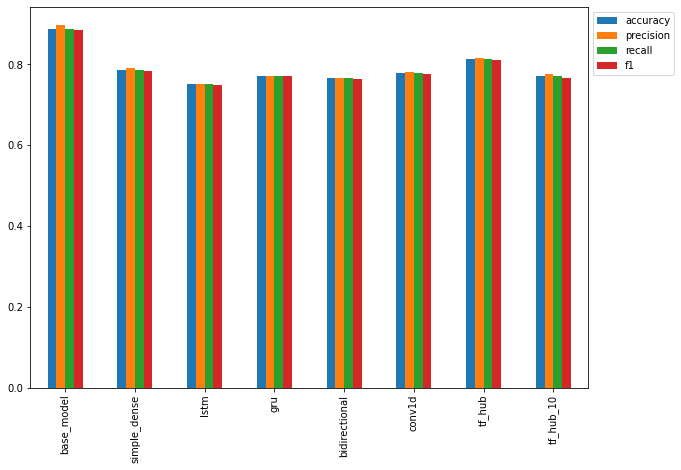

In [118]:
# Plot and compare all of the model metrics
all_metrics.plot(kind='bar',figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

Looks like our pretrained USE TensorFlow Hub models have the best performance, even the one with only 10% of the training data seems to outperform the other models. This goes to show the power of transfer learning.

How about we drill down and get the F1-score's of each model?

<AxesSubplot:>

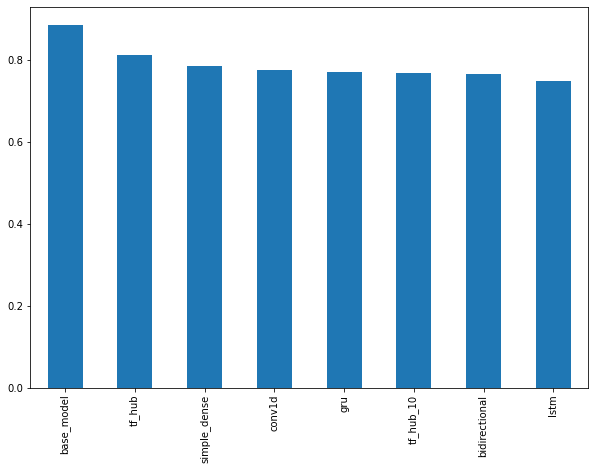

In [120]:
all_metrics.sort_values("f1",ascending=False)['f1'].plot(kind='bar',figsize=(10,7))

Drilling down into a single metric we see our USE TensorFlow Hub models performing  better than all of the other models. Interestingly, the baseline's F1-score isn't too far off the rest of the deeper models.

We can also visualize all of our model's training logs using TensorBoard.dev.

## Combining our models (model ensembling/stacking)

Many production systems use an **ensemble** (multiple different models combined) of models to make a prediction.

The idea behind model stacking is that if several uncorrelated models agree on a prediction, then the prediction must be more robust than a prediction made by a singular model.

The keyword in the sentence above is **uncorrelated**, which is another way of saying, different types of models. For example, in our case, we might combine our baseline, our bidirectional model and our TensorFlow Hub USE model.

Although these models are all trained on the same data, they all have a different way of finding patterns.

If we were to use three similarly trained models, such as three LSTM models, the predictions they output will likely be very similar.

Think of it as trying to decide where to eat with your friends. If you all have similar tastes, you'll probably all pick the same restaurant. But if you've all got different tastes and still end up picking the same restaurant, the restaurant must be good.

Since we're working with a classification problem, there are a few of ways we can combine our models:
1. **Averaging** - Take the output prediction probabilities of each model for each sample, combine them and then average them.
2. **Majority vote (mode)** - Make class predictions with each of your models on all samples, the predicted class is the one in majority. For example, if three different models predict `[1, 0, 1]` respectively, the majority class is `1`, therefore, that would be the predicted label.
3. **Model stacking** - Take the outputs of each of your chosen models and use them as inputs to another model.

> 📖 **Resource:** The above methods for model stacking/ensembling were adapted from Chapter 6 of the [Machine Learning Engineering Book](http://www.mlebook.com/wiki/doku.php) by Andriy Burkov. If you're looking to enter the field of machine learning engineering, not only building models but production-scale machine learning systems, I'd highly recommend reading it in its entirety.

Again, the concept of model stacking is best seen in action.

We're going to combine our baseline model (`model_0`), LSTM model (`model_2`) and our USE model trained on the full training data (`model_6`) by averaging the combined prediction probabilities of each.

In [129]:
# Get mean pred probs for 3 models
base_pred_probs=np.max(model_0.predict_proba(x_val),axis=1) 
combined_pred_probs = base_pred_probs + tf.squeeze(model_6.predict(x_val),axis=1) + tf.squeeze(model_1.predict(x_val),axis=1)
combined_preds = tf.round(combined_pred_probs/3)
combined_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [143]:
ensemble_metrics = eval_model(y_true=y_val,y_pred=combined_preds)
ensemble_metrics

{'accuracy': 81.10236220472441,
 'precision': 0.8108054976576626,
 'recall': 0.8110236220472441,
 'f1': 0.8107737872203897}

In [145]:
#Add our combined model;s metrics to the results dataframe
all_metrics = pd.DataFrame({"base_model":baseline_results,
                            "simple_dense":model_1_metrics,
                            "lstm":model_2_metrics,
                            "gru":model_3_metrics,
                            "bidirectional":model_4_metrics,
                            "conv1d":model_5_metrics,
                            "tf_hub":model_6_metrics,
                            "tf_hub_10":model_7_metrics,
                            "ensemble":ensemble_metrics
                           })

In [146]:
all_metrics.transpose()

,accuracy,precision,recall,f1
base_model,88.716976,0.897228,0.887170,0.884715
simple_dense,78.740157,0.791492,0.787402,0.784697
lstm,75.065617,0.751008,0.750656,0.748927
gru,77.165354,0.771567,0.771654,0.770699
bidirectional,76.640420,0.766590,0.766404,0.765121
conv1d,77.821522,0.780752,0.778215,0.775881
tf_hub,81.233596,0.814880,0.812336,0.810687
tf_hub_10,77.034121,0.775563,0.770341,0.766706
ensemble,81.102362,0.810805,0.811024,0.810774


Wonderful! We've got a combined predictions array of different classes, let's evaluate them against the true labels and add our stacked model's results to our `all_model_results` DataFrame.

## Saving and loading a trained model

Although training time didn't take very long, it's good practice to save your trained models to avoid having to retrain them.

Saving your models also enables you to export them for use elsewhere outside of your notebooks, such as in a web application.

There are two main ways of [saving a model in TensorFlow](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model):
1. The `HDF5` format. 
2. The `SavedModel` format (default).

Let's take a look at both.

In [152]:
# Save tf hub sentence encoder model to hdf5 format
model_6.save("model_6.h5")

In [153]:
model_6_loaded = tf.keras.models.load_model("model_6.h5",custom_objects={"KerasLayer":hub.KerasLayer})

In [154]:
# How loaded model perform
model_6_loaded.evaluate(x_val,y_val)

24/24 [==============================] - 3s 28ms/step - loss: 0.4309 - accuracy: 0.8123


[0.43088313937187195, 0.8123359680175781]

In [155]:
# save tf hub sentence encoder model to SavedModel format (default)
model_6.save("model_hub_SavedModel_format")

INFO:tensorflow:Assets written to: model_hub_SavedModel_format\assets


INFO:tensorflow:Assets written to: model_hub_SavedModel_format\assets


If you use SavedModel format (default), you can reload your model without specifying custom objects using the [`tensorflow.keras.models.load_model()`](https://www.tensorflow.org/tutorials/keras/save_and_load) function.

In [156]:
loaded_model  = tf.keras.models.load_model("model_hub_SavedModel_format")

In [157]:
#Evaluate loaded model format
loaded_model.evaluate(x_val,y_val)

24/24 [==============================] - 1s 17ms/step - loss: 0.4309 - accuracy: 0.8123


[0.43088313937187195, 0.8123359680175781]

Calling the `save()` method on our target model and passing it a filepath allows us to save our model in the `SavedModel` format. 

If you save a model as a `HDF5`, when loading it back in, you need to let [TensorFlow know about any custom objects you've used](https://www.tensorflow.org/tutorials/keras/save_and_load#saving_custom_objects) (e.g. components which aren't built from pure TensorFlow, such as TensorFlow Hub components).

As you can see saving and loading our model with either format results in the same performance.

> 🤔 **Question:** Should you used the `SavedModel` format or `HDF5` format?

For most use cases, the `SavedModel` format will suffice. However, this is a TensorFlow specific standard. If you need a more general-purpose data standard, `HDF5` might be better. For more, check out the [TensorFlow documentation on saving and loading models](https://www.tensorflow.org/tutorials/keras/save_and_load).

## Finding the most wrong examples

We mentioned before that if many of our modelling experiments are returning similar results, despite using different kinds of models, it's a good idea to return to the data and inspect why this might be.

One of the best ways to inspect your data is to sort your model's predictions and find the samples it got *most* wrong, meaning, what predictions had a high prediction probability but turned out to be wrong.

Once again, visualization is your friend. Visualize, visualize, visualize.

To make things visual, let's take our best performing model's prediction probabilities and classes along with the validation samples (text and ground truth labels) and combine them in a pandas DataFrame.

* If our best model still isn't perfect, what examples is it getting wrong? 
* Which ones are the *most* wrong?
* Are there some labels which are wrong? E.g. the model gets it right but the ground truth label doesn't reflect this

In [163]:
# Create dataframe with validation sentences and best performing model perdictions
val_df = pd.DataFrame({"text":x_val,
                       "target":y_val,
                       "pred":y_pred,
                       "prob":tf.squeeze(np.max(loaded_model.predict(x_val),axis=1)) 
                      })

val_df

,text,target,pred,prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.144432
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.727150
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.985665
3,@camilacabello97 Internally and externally scr...,1,0.0,0.197409
4,Radiation emergency #preparedness starts with ...,1,1.0,0.734170
...,...,...,...,...
757,That's the ultimate road to destruction,0,0.0,0.101705
758,@SetZorah dad why dont you claim me that mean ...,0,0.0,0.107102
759,FedEx will no longer transport bioterror patho...,0,1.0,0.864676
760,Crack in the path where I wiped out this morni...,0,0.0,0.702342


Oh yeah! Now let's find our model's wrong predictions (where `target != pred`) and sort them by their prediction probability (the `pred_prob` column).

In [167]:
# find the wrong predictions and sort by predictions probabilities
most_wrong = val_df[val_df["target"]!=val_df["pred"]].sort_values("prob",ascending=False)
most_wrong

,text,target,pred,prob
362,Just got sent this photo from Ruby #Alaska as ...,1,0.0,0.955130
403,As a result of heavy rains in #Bangladeshaffec...,1,0.0,0.923787
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910481
740,Refugio oil spill may have been costlier bigge...,1,0.0,0.882159
499,Another White mass murderer. Thank God I live ...,1,0.0,0.866604
...,...,...,...,...
233,I get to smoke my shit in peace,1,0.0,0.041451
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.039261
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038593
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.036272


Finally, we can write some code to visualize the sample text, truth label, prediction class and prediction probability. Because we've sorted our samples by prediction probability, viewing samples from the head of our `most_wrong` DataFrame will show us false positives.

A reminder:
* `0` = Not a real diaster Tweet
* `1` = Real diaster Tweet

In [170]:
# Check the false positives (model predicted 1 when should be 0)
for row in most_wrong[:10].itertuples():
    _,text,target,pred,prob = row
    print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
    print(f"Text:\n{text}\n")

Target: 1, Pred: 0, Prob: 0.9551297426223755
Text:
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 

Target: 1, Pred: 0, Prob: 0.9237873554229736
Text:
As a result of heavy rains in #Bangladeshaffected lands are inundated by flood waters-land looks like rivers at high tide #BangladeshFlood

Target: 0, Pred: 1, Prob: 0.9104807376861572
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

Target: 1, Pred: 0, Prob: 0.8821593523025513
Text:
Refugio oil spill may have been costlier bigger than projected http://t.co/gtHddzAvhg #LosAngelesTimes #latimes #news

Target: 1, Pred: 0, Prob: 0.8666043281555176
Text:
Another White mass murderer. Thank God I live in California.  https://t.co/4COg0OTiWn

Target: 0, Pred: 1, Prob: 0.8646756410598755
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

Target: 1, Pred: 0, Prob: 0.8559896945953369
Text:
Refugio oil spill may have bee

We can view the bottom end of our `most_wrong` DataFrame to inspect false negatives (model predicts 0, not a real diaster Tweet, when it should've predicted 1, real diaster Tweet).

In [171]:
# Check the false positives (model predicted 1 when should be 0)
for row in most_wrong[-10:].itertuples():
    _,text,target,pred,prob = row
    print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
    print(f"Text:\n{text}\n")

Target: 1, Pred: 0, Prob: 0.06304335594177246
Text:
@BoyInAHorsemask its a panda trapped in a dogs body

Target: 1, Pred: 0, Prob: 0.0627950131893158
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

Target: 1, Pred: 0, Prob: 0.060608088970184326
Text:
VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP WATCH 241487 http://t.co/yFy3nkkcoH http://t.co/KNEhVvOHVK

Target: 1, Pred: 0, Prob: 0.0573178231716156
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

Target: 1, Pred: 0, Prob: 0.045355528593063354
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

Target: 1, Pred: 0, Prob: 0.04145139455795288
Text:
I get to smoke my shit in peace

Target: 1, Pred: 0, Prob: 0.03926113247871399
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like

## Making predictions on the test dataset

Alright we've seen how our model's perform on the validation set.

But how about the test dataset?

We don't have labels for the test dataset so we're going to have to make some predictions and inspect them for ourselves.

Let's write some code to make predictions on random samples from the test dataset and visualize them.

In [186]:
# Making predictions on test datastet
probs = loaded_model.predict(x_pred)
preds = tf.squeeze(tf.round(probs))
for i in range(10):
    print(f"Pred: {int(preds[i])}, Prob: {probs[i]}")
    print(f"Text:\n{text}\n")

Pred: 1, Prob: [0.5727566]
Text:
Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube

Pred: 1, Prob: [0.876163]
Text:
Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube

Pred: 1, Prob: [0.8143084]
Text:
Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube

Pred: 1, Prob: [0.92398953]
Text:
Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube

Pred: 1, Prob: [0.9490781]
Text:
Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube

Pred: 1, Prob: [0.59355354]
Text:
Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube

Pred: 0, Prob: [0.06413975]
Text:
Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube

Pred: 0, Prob: [0.04735658]
Text:
Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube

Pred: 0, Prob: [0.04297906]
Text:
Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 vi

How do our model's predictions look on the test dataset?

It's important to do these kind of visualization checks as often as possible to get a glance of how your model performs on unseen data and subsequently how it might perform on the real test: Tweets from the wild.

## Predicting on Tweets from the wild

How about we find some Tweets and use our model to predict whether or not they're about a diaster or not?

To start, let's take one of my own [Tweets on living life like an ensemble model](https://twitter.com/mrdbourke/status/1313649328351662082). 

In [196]:
def predict_on_sentence(model,sentence):
    '''
    Uses model to make prediction on sentence
    Args:
        model: model
        sentence: input tweet
    Return:
        Return the senence. the predicted label and the prediction probability
    '''
    prob = model.predict([sentence])
    pred = tf.squeeze(tf.round(prob))
    print(f"Pred: {int(pred)}, Prob: {prob[0][0]}","(real disaster)" if pred ==1 else "(not real disaster)" )
    print(f"Text:\n{sentence}\n")

In [197]:
predict_on_sentence(loaded_model,"Is this a real disater tweet")

Pred: 0, Prob: 0.11744141578674316 (not real disaster)
Text:
Is this a real disater tweet



In [198]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"
predict_on_sentence(loaded_model,beirut_tweet_1)

Pred: 1, Prob: 0.9625466465950012 (real disaster)
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon



In [199]:
# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"
predict_on_sentence(loaded_model,beirut_tweet_2)

Pred: 1, Prob: 0.96785569190979 (real disaster)
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon



Looks like our model is performing as expected, predicting both of the diaster Tweets as actual diasters.

> 🔑 **Note:** The above examples are cherry-picked and are cases where you'd expect a model to function at high performance. For actual production systems, you'll want to continaully perform tests to see how your model is performing.

## The speed/score tradeoff

One of the final tests we're going to do is to find the speed/score tradeoffs between our best model and baseline model.

Why is this important?

Although it can be tempting to just choose the best performing model you find through experimentation, this model might not actually work in a production setting.

Put it this way, imagine you're Twitter and receive 1 million Tweets per hour (this is a made up number, the actual number is much higher). And you're trying to build a diaster detection system to read Tweets and alert authorities with details about a diaster in close to real-time.

Compute power isn't free so you're limited to a single compute machine for the project. On that machine, one of your models makes 10,000 predictions per second at 80% accuracy where as another one of your models (a larger model) makes 100 predictions per second at 85% accuracy.

Which model do you choose?

Is the second model's performance boost worth missing out on the extra capacity?

Of course, there are many options you could try here, such as sending as many Tweets as possible to the first model and then sending the ones which the model is least certain of to the second model. 

The point here is to illustrate the best model you find through experimentation, might not be the model you end up using in production.

To make this more concrete, let's write a function to take a model and a number of samples and time how long the given model takes to make predictions on those samples.

In [205]:
# Calculate the time of predictions
import time
def pred_timer(model,samples):
    '''
    Times how long a model takes to make predictions on samples
    Args:
        model: a trained model
        sample: a list of samples
    Return:
        total_time: total elapsed time for model to make predictions on samples
        time_per_pred: time in seconds per single samples
    '''
    start_time = time.perf_counter() # get start time
    model.predict(samples) # make predictions
    total_time = time.perf_counter() - start_time # calculate how liong predictions took to make
    time_per_pred = total_time/len(samples) # find prediction time per sample
    return total_time,time_per_pred

In [209]:
# Calculate TF hub sentence encoder prediction times
total_time1,time_per_pred1=pred_timer(loaded_model,x_pred)
print(f"Total time: {total_time}, Time per each prediction: {time_per_pred}")

Total time: 0.23768991800170625, Time per each prediction: 7.284398345133504e-05


In [210]:
# Calculate Naive Bayse prediction times
total_time2,time_per_pred2=pred_timer(model_0,x_pred)
print(f"Total time: {total_time}, Time per each prediction: {time_per_pred}")

Total time: 0.23768991800170625, Time per each prediction: 7.284398345133504e-05


It seems with our current hardware (in my case, I'm using a Google Colab notebook) our best performing model takes over 10x the time to make predictions as our baseline model.

Is that extra prediction time worth it?

Let's compare time per prediction versus our model's F1-scores.

Text(0, 0.5, 'F1-score')

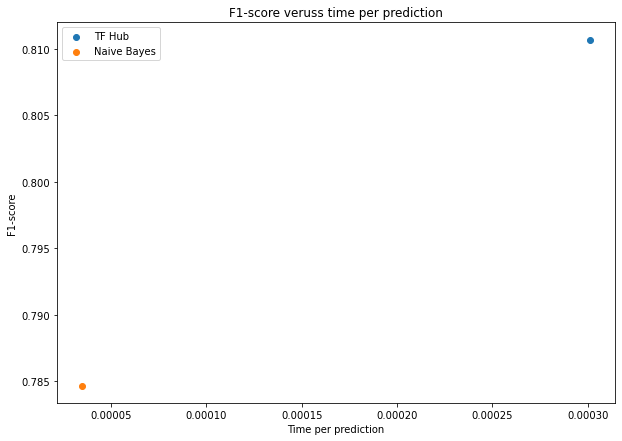

In [211]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(time_per_pred1,model_6_metrics["f1"],label="TF Hub")
plt.scatter(time_per_pred2,model_1_metrics["f1"],label="Naive Bayes")
plt.legend()
plt.title("F1-score veruss time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score")

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-ideal-performance-speed-of-pred-tradeoff-highlighted.png)
*Ideal position for speed and performance tradeoff model (fast predictions with great results).*

Of course, the ideal position for each of these dots is to be in the top left of the plot (low time per prediction, high F1-score). 

In our case, there's a clear tradeoff for time per prediction and performance. Our best performing model takes an order of magnitude longer per prediction but only results in a few F1-score point increase.

This kind of tradeoff is something you'll need to keep in mind when incorporating machine learning models into your own applications.

# Exercises

1. Rebuild, compile and train `model_1`, `model_2` and `model_5` using the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) instead of the Functional API.
2. Retrain the baseline model with 10% of the training data. How does perform compared to the Universal Sentence Encoder model with 10% of the training data?
3. Try fine-tuning the TF Hub Universal Sentence Encoder model by setting `training=True` when instantiating it as a Keras layer.

```
We can use this encoding layer in place of our text_vectorizer and embedding layer

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True) # turn training on to fine-tune the TensorFlow Hub model
```
4. Retrain the best model you've got so far on the whole training set (no validation split). Then use this trained model to make predictions on the test dataset and format the predictions into the same format as the `sample_submission.csv` file from Kaggle (see the Files tab in Colab for what the `sample_submission.csv` file looks like). Once you've done this, [make a submission to the Kaggle competition](https://www.kaggle.com/c/nlp-getting-started/data), how did your model perform?
5. Combine the ensemble predictions using the majority vote (mode), how does this perform compare to averaging the prediction probabilities of each model?
6. Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.

# Extra-curriculum 

To practice what you've learned, a good idea would be to spend an hour on 3 of the following (3-hours total, you could through them all if you want) and then write a blog post about what you've learned.

* For an overview of the different problems within NLP and how to solve them read through: 
 * [A Simple Introduction to Natural Language Processing](https://becominghuman.ai/a-simple-introduction-to-natural-language-processing-ea66a1747b32)
 * [How to solve 90% of NLP problems: a step-by-step guide](https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e)
* Go through [MIT's Recurrent Neural Networks lecture](https://youtu.be/SEnXr6v2ifU). This will be one of the greatest additions to what's happening behind the RNN model's you've been building.
* Read through the [word embeddings page on the TensorFlow website](https://www.tensorflow.org/tutorials/text/word_embeddings). Embeddings are such a large part of NLP. We've covered them throughout this notebook but extra practice would be well worth it. A good exercise would be to write out all the code in the guide in a new notebook. 
* For more on RNN's in TensorFlow, read and reproduce [the TensorFlow RNN guide](https://www.tensorflow.org/guide/keras/rnn). We've covered many of the concepts in this guide, but it's worth writing the code again for yourself.
* Text data doesn't always come in a nice package like the data we've downloaded. So if you're after more on preparing different text sources for being with your TensorFlow deep learning models, it's worth checking out the following:
 * [TensorFlow text loading tutorial](https://www.tensorflow.org/tutorials/load_data/text).
  * [Reading text files with Python](https://realpython.com/read-write-files-python/) by Real Python.
* This notebook has focused on writing NLP code. For a mathematically rich overview of how NLP with Deep Learning happens, read [Standford's Natural Language Processing with Deep Learning lecture notes Part 1](https://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes01-wordvecs1.pdf).  
  * For an even deeper dive, you could even do the whole [CS224n](http://web.stanford.edu/class/cs224n/) (Natural Language Processing with Deep Learning) course. 
* Great blog posts to read:
  * Andrei Karpathy's [The Unreasonable Effectiveness of RNNs](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) dives into generating Shakespeare text with RNNs.
  * [Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT](https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794) by Mauro Di Pietro. An overview of different techniques for turning text into numbers and then classifying it.
  * [What are word embeddings?](https://machinelearningmastery.com/what-are-word-embeddings/) by Machine Learning Mastery.
* Other topics worth looking into:
  * [Attention mechanisms](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/). These are a foundational component of the transformer architecture and also often add improvments to deep NLP models.
  * [Transformer architectures](http://jalammar.github.io/illustrated-transformer/). This model architecture has recently taken the NLP world by storm, achieving state of the art on many benchmarks. However, it does take a little more processing to get off the ground, the [HuggingFace Models (formerly HuggingFace Transformers) library](https://huggingface.co/models/) is probably your best quick start.
    * And now [HuggingFace even have their own course](https://huggingface.co/course/chapter1) on how their library works! I haven't done it but anything HuggingFace makes is world-class.



# References

[naive-bayes](https://viblo.asia/p/mo-hinh-phan-lop-naive-bayes-vyDZO0A7lwj)